In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
class OnePieceDataset(Dataset):

    def __init__(self):
        xy = torch.load('onepiecedata.pt')

        # Images saved in tuples, stacking adds a new dimension as 'batch'
        self.x = torch.stack([tuple[0] for tuple in xy])
        self.y = [tuple[1] for tuple in xy]
        self.num_samples = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.num_samples


def get_data_loaders(batch_size):

    dataset = OnePieceDataset()
    X_train, X_test, y_train, y_test = train_test_split(dataset.x, dataset.y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

    train = TensorDataset(X_train, torch.tensor(y_train))
    val = TensorDataset(X_val, torch.tensor(y_val))
    test = TensorDataset(X_test, torch.tensor(y_test))

    train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(dataset=val, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=True)

    return train_loader, validation_loader, test_loader


### The Network

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


class CNN(nn.Module):

    def __init__(self, num_classes) -> None:
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=1)
        )

        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=256, out_features=512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.LeakyReLU(),
            nn.BatchNorm1d(256),
        )

        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = self.fc3(x)
        return x

# model = CNN(num_classes=18).to(device)
# _ = model.forward(torch.rand([3, 3, 150, 150]).to(device))

cuda


## Parameters

In [5]:
num_classes = 18
lr = 3e-4
num_epochs = 30

train_loader, val_loader, test_loader = get_data_loaders(batch_size=64)
model = CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [6]:
def get_validation_loss():
    model.eval()
    val_loss = []
    with torch.no_grad():
      for i, (data, targets) in enumerate(val_loader):

        data = data.float().to(device)

        # data = data.to(device)
        targets = targets.to(device)

        # forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        val_loss.append(loss.item())

    model.train()
    return np.mean(val_loss)


In [10]:
def train_model():

    train_loss = []
    val_loss = []
    acc = []
    val_acc = []


    for epoch in range(num_epochs):

        epoch_losses = []

        # print(f"[TRAINING] epoch {epoch+1}")
        for i, (data, targets) in enumerate(train_loader):

            data = data.float().to(device)

            # data = data.to(device)
            targets = targets.to(device)

            # forward pass
            scores = model(data)
            loss = criterion(scores, targets)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # gradient descent
            optimizer.step()

            if (i+1) % 20 == 0:
                epoch_losses.append(loss.item())

        # Epoch validation and training loss
        mean_epoch_loss = np.mean(epoch_losses)
        val_epoch_loss = get_validation_loss()

        # Get training and validation accuracy for the epoch
        _, _, val_correct, val_samples = check_accuracy(val_loader, model)
        _, _, train_correct, train_samples = check_accuracy(train_loader, model)
        val_epoch_acc = val_correct/val_samples
        train_epoch_acc = train_correct/train_samples

        print(
            f"epoch: [{epoch+1}/{num_epochs}], loss: {mean_epoch_loss:.4f}, acc: {train_epoch_acc:.4f}, val_loss: {val_epoch_loss:.4f}, val_acc: {val_epoch_acc:.4f}"
        )
        train_loss.append((epoch, mean_epoch_loss))
        val_loss.append((epoch, val_epoch_loss))
        acc.append((epoch, train_epoch_acc))
        val_acc.append((epoch, val_epoch_acc))

    print("Model finished training.\n")
    return train_loss, val_loss, acc, val_acc



In [8]:
def check_accuracy(loader, model, msg=""):
    print(msg)
    y_true = []
    y_pred = []

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            y = y.to(device)
            x = x.float().to(device)

            scores = model(x)
            predictions = torch.argmax(scores, dim=1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

            y_true.append(y.cpu())
            y_pred.append(predictions.cpu())
    model.train()
    return torch.cat(y_true), torch.cat(y_pred), num_correct, num_samples


In [11]:
loss_metrics, val_loss_metrics, train_acc, val_acc = train_model()

# Final train set accuracy
_, _, num_correct, num_samples = check_accuracy(train_loader, model, msg="[EVAL] Checking accuracy on training dataset")
print(f"[EVAL] Correctly classified {num_correct}/{num_samples} - Accuracy {(float(num_correct)/float(num_samples))*100:.2f}%")

# Final test set accuracy
y_true, y_pred, num_correct, num_samples = check_accuracy(test_loader, model, msg="[EVAL] Checking accuracy on test dataset")
print(f"[EVAL] Correctly classified {num_correct}/{num_samples} - Accuracy {(float(num_correct)/float(num_samples))*100:.2f}%")






epoch: [1/30], loss: 2.4912, acc: 0.2398, val_loss: 2.3933, val_acc: 0.2512




epoch: [2/30], loss: 2.0677, acc: 0.3446, val_loss: 2.2485, val_acc: 0.2981




epoch: [3/30], loss: 1.7207, acc: 0.4321, val_loss: 1.8569, val_acc: 0.4095




epoch: [4/30], loss: 1.6689, acc: 0.4664, val_loss: 1.7861, val_acc: 0.4436




epoch: [5/30], loss: 1.4572, acc: 0.5558, val_loss: 1.6793, val_acc: 0.4989




epoch: [6/30], loss: 1.2001, acc: 0.6919, val_loss: 1.2823, val_acc: 0.5947




epoch: [7/30], loss: 1.1158, acc: 0.7444, val_loss: 1.1949, val_acc: 0.6466




epoch: [8/30], loss: 0.8773, acc: 0.6812, val_loss: 1.4699, val_acc: 0.5536




epoch: [9/30], loss: 0.9134, acc: 0.7119, val_loss: 1.4344, val_acc: 0.5593




epoch: [10/30], loss: 0.7487, acc: 0.8317, val_loss: 1.1413, val_acc: 0.6487




epoch: [11/30], loss: 0.6192, acc: 0.8662, val_loss: 1.1445, val_acc: 0.6487




epoch: [12/30], loss: 0.5775, acc: 0.7878, val_loss: 1.4356, val_acc: 0.6033




epoch: [13/30], loss: 0.3207, acc

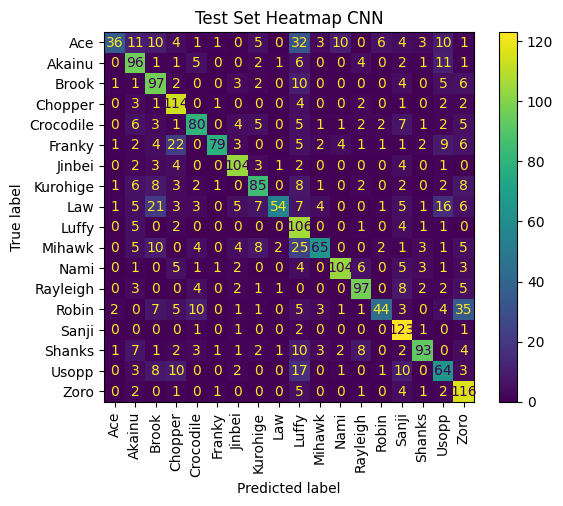

In [12]:
cnfm = metrics.confusion_matrix(y_true, y_pred)
class_labels = [
    'Ace',
    'Akainu',
    'Brook',
    'Chopper',
    'Crocodile',
    'Franky',
    'Jinbei',
    'Kurohige',
    'Law',
    'Luffy',
    'Mihawk',
    'Nami',
    'Rayleigh',
    'Robin',
    'Sanji',
    'Shanks',
    'Usopp',
    'Zoro'
]
displayed_cm = metrics.ConfusionMatrixDisplay(cnfm, display_labels=class_labels)
displayed_cm.plot()
plt.xticks(rotation=90)
plt.title('Test Set Heatmap CNN')
plt.show()

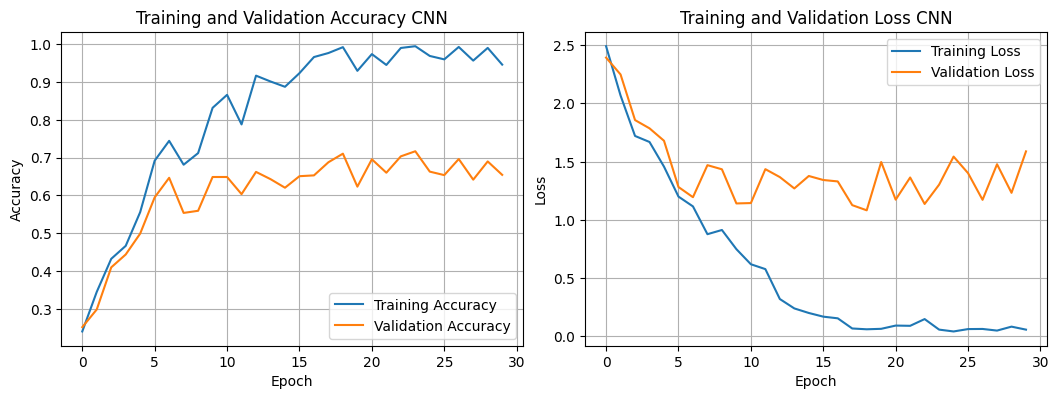

In [21]:
fig = plt.figure(figsize=(10, 4.75))
subfigs = fig.subfigures(1, 2, wspace=0.1)

acc_fig = subfigs[0].add_subplot(1, 1, 1)
loss_fig = subfigs[1].add_subplot(1, 1, 1)

# Subfigure 1: Accuracy
acc_fig.plot([x[0] for x in train_acc], [x[1].cpu() for x in train_acc], label='Training Accuracy')
acc_fig.plot([x[0] for x in val_acc], [x[1].cpu() for x in val_acc], label='Validation Accuracy')
acc_fig.set_xlabel('Epoch')
acc_fig.set_ylabel('Accuracy')
acc_fig.set_title('Training and Validation Accuracy CNN')
acc_fig.legend()
acc_fig.grid(True)

# Subfigure 2: Loss
loss_fig.plot([x[0] for x in loss_metrics], [x[1] for x in loss_metrics], label='Training Loss')
loss_fig.plot([x[0] for x in val_loss_metrics], [x[1] for x in val_loss_metrics], label='Validation Loss')
loss_fig.set_xlabel('Epoch')
loss_fig.set_ylabel('Loss')
loss_fig.set_title('Training and Validation Loss CNN')
loss_fig.legend()
loss_fig.grid(True)

plt.tight_layout()
plt.show()